In [1]:
from beqanalyser import DistanceParams
from beqanalyser.analyser import HDBSCANParams, build_all_composites
import numpy as np
from collections import defaultdict
from beqanalyser.loader import load, load_or_compute_distance_matrix

min_freq = 5
max_freq = 50
fan_counts = (5, 10, 20, 50, 100)
use_constraints = True

catalogue, data_hash = load()
by_author_by_year = defaultdict(lambda: defaultdict(int))

freqs = catalogue[0].mag_freqs
in_band_freqs = freqs[(freqs >= min_freq) & (freqs <= max_freq)]
responses_db = np.array([f.mag_db - f.mag_db[-1] for f in catalogue])

In [2]:
distance_params = DistanceParams()

full_distance_matrix = load_or_compute_distance_matrix(
    input_curves=responses_db,
    freqs=freqs,
    band=(min_freq, max_freq),
    distance_params=distance_params,
    data_hash=data_hash,
)

In [3]:

params = [
    HDBSCANParams(
        min_cluster_size=50, min_samples=10, cluster_selection_epsilon=10.0
    ),
    HDBSCANParams(
        min_cluster_size=50, min_samples=10, cluster_selection_epsilon=10.0
    ),
    HDBSCANParams(
        min_cluster_size=50, min_samples=8, cluster_selection_epsilon=10.0
    ),
    HDBSCANParams(
        min_cluster_size=50, min_samples=5, cluster_selection_epsilon=10.0
    ),
    HDBSCANParams(
        min_cluster_size=20, min_samples=5, cluster_selection_epsilon=10.0
    ),
    HDBSCANParams(
        min_cluster_size=20, min_samples=5, cluster_selection_epsilon=10.0
    ),
]

result = build_all_composites(
    input_curves=responses_db,
    freqs=freqs,
    band=(min_freq, max_freq),
    fan_counts=fan_counts,
    iteration_params=params,
    distance_params=distance_params,
    full_distance_matrix=full_distance_matrix,
    final_assignment_threshold_multiplier=1.0
)

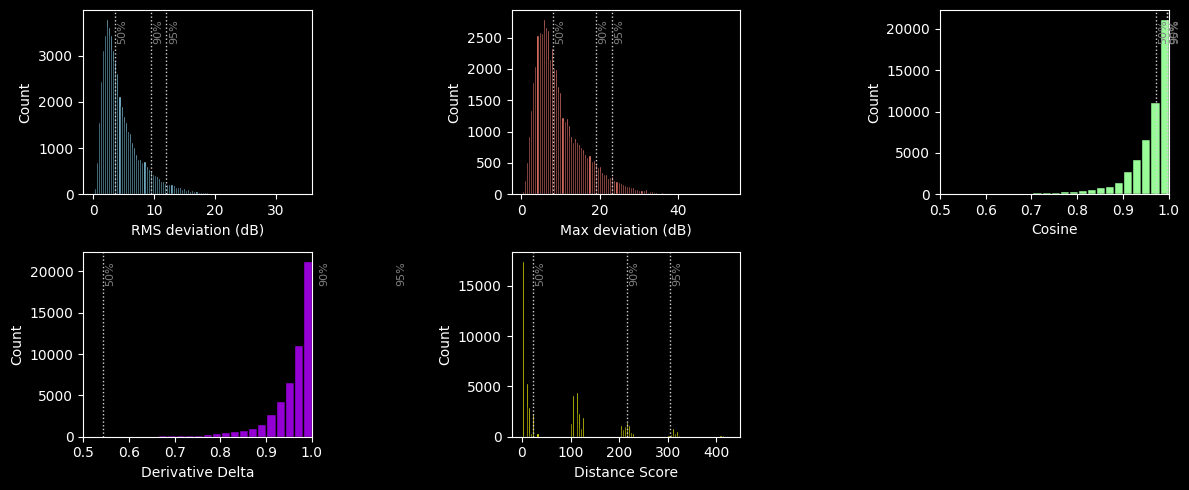

In [4]:
from beqanalyser.reporter import plot_distance_histograms

plot_distance_histograms(result.composites)

In [5]:
from beqanalyser.reporter import plot_distance_by_composite

plot_distance_by_composite(result.composites, in_band_freqs)

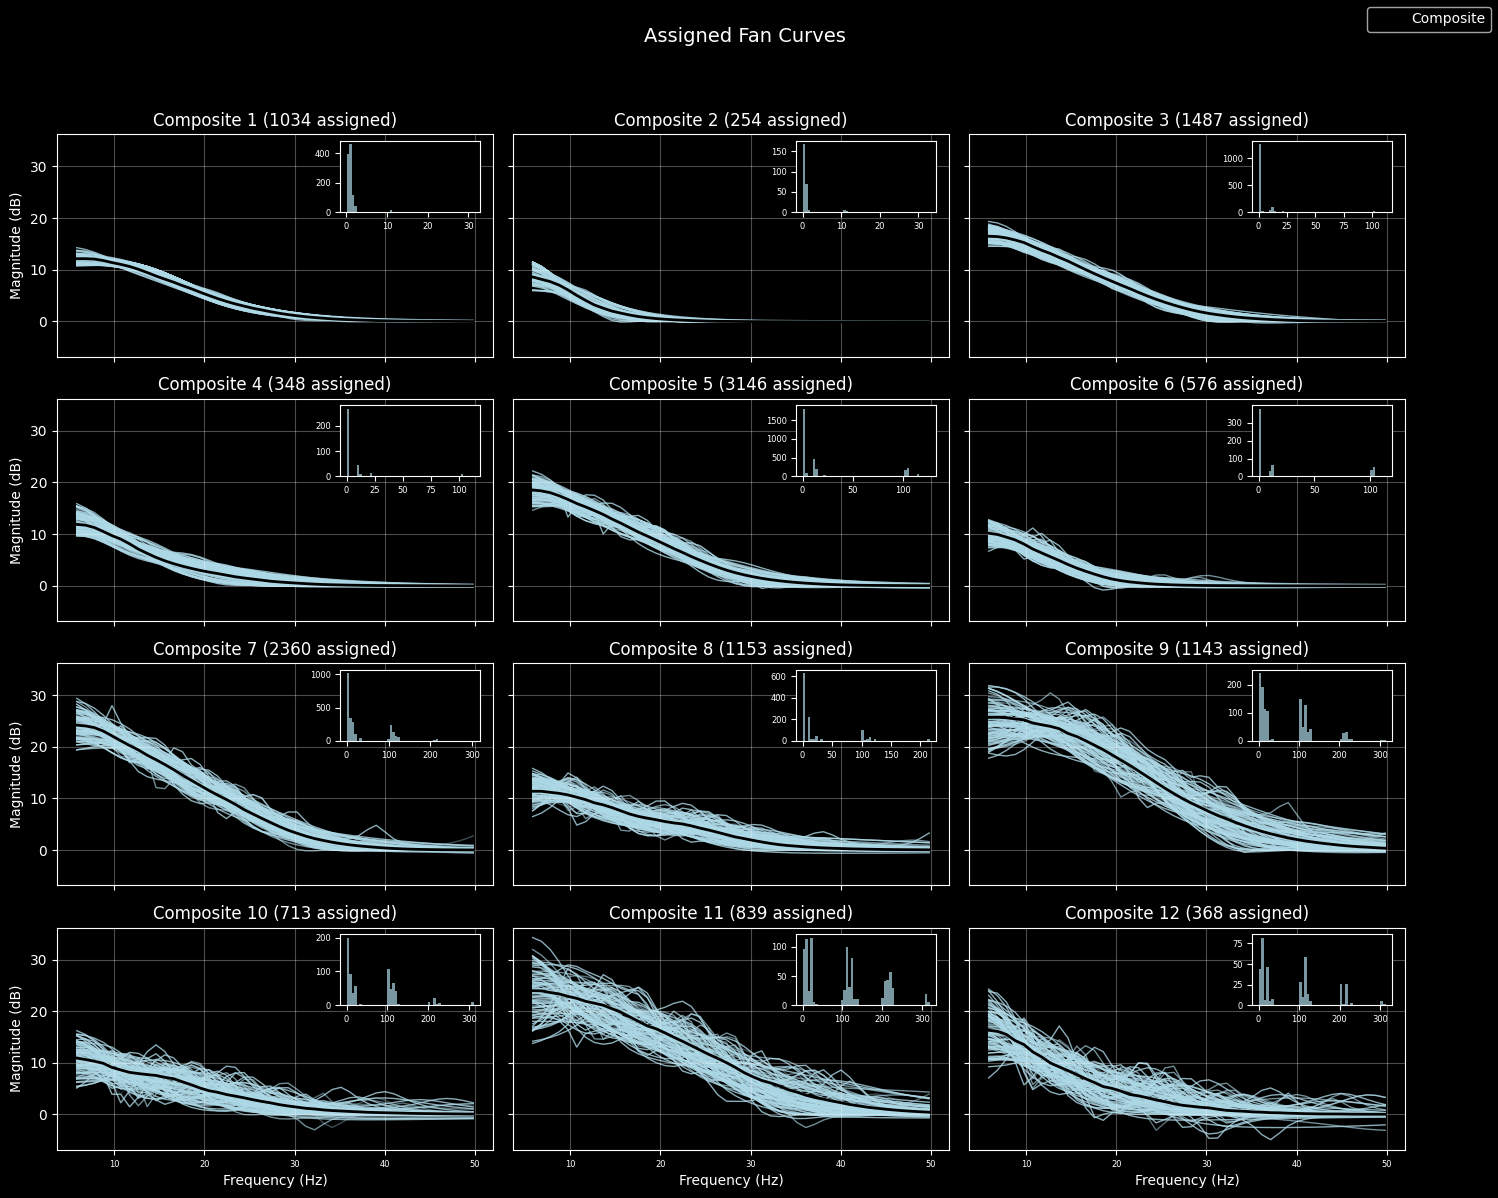

In [6]:
from beqanalyser.reporter import plot_assigned_fan_curves

plot_assigned_fan_curves(result.composites, in_band_freqs)

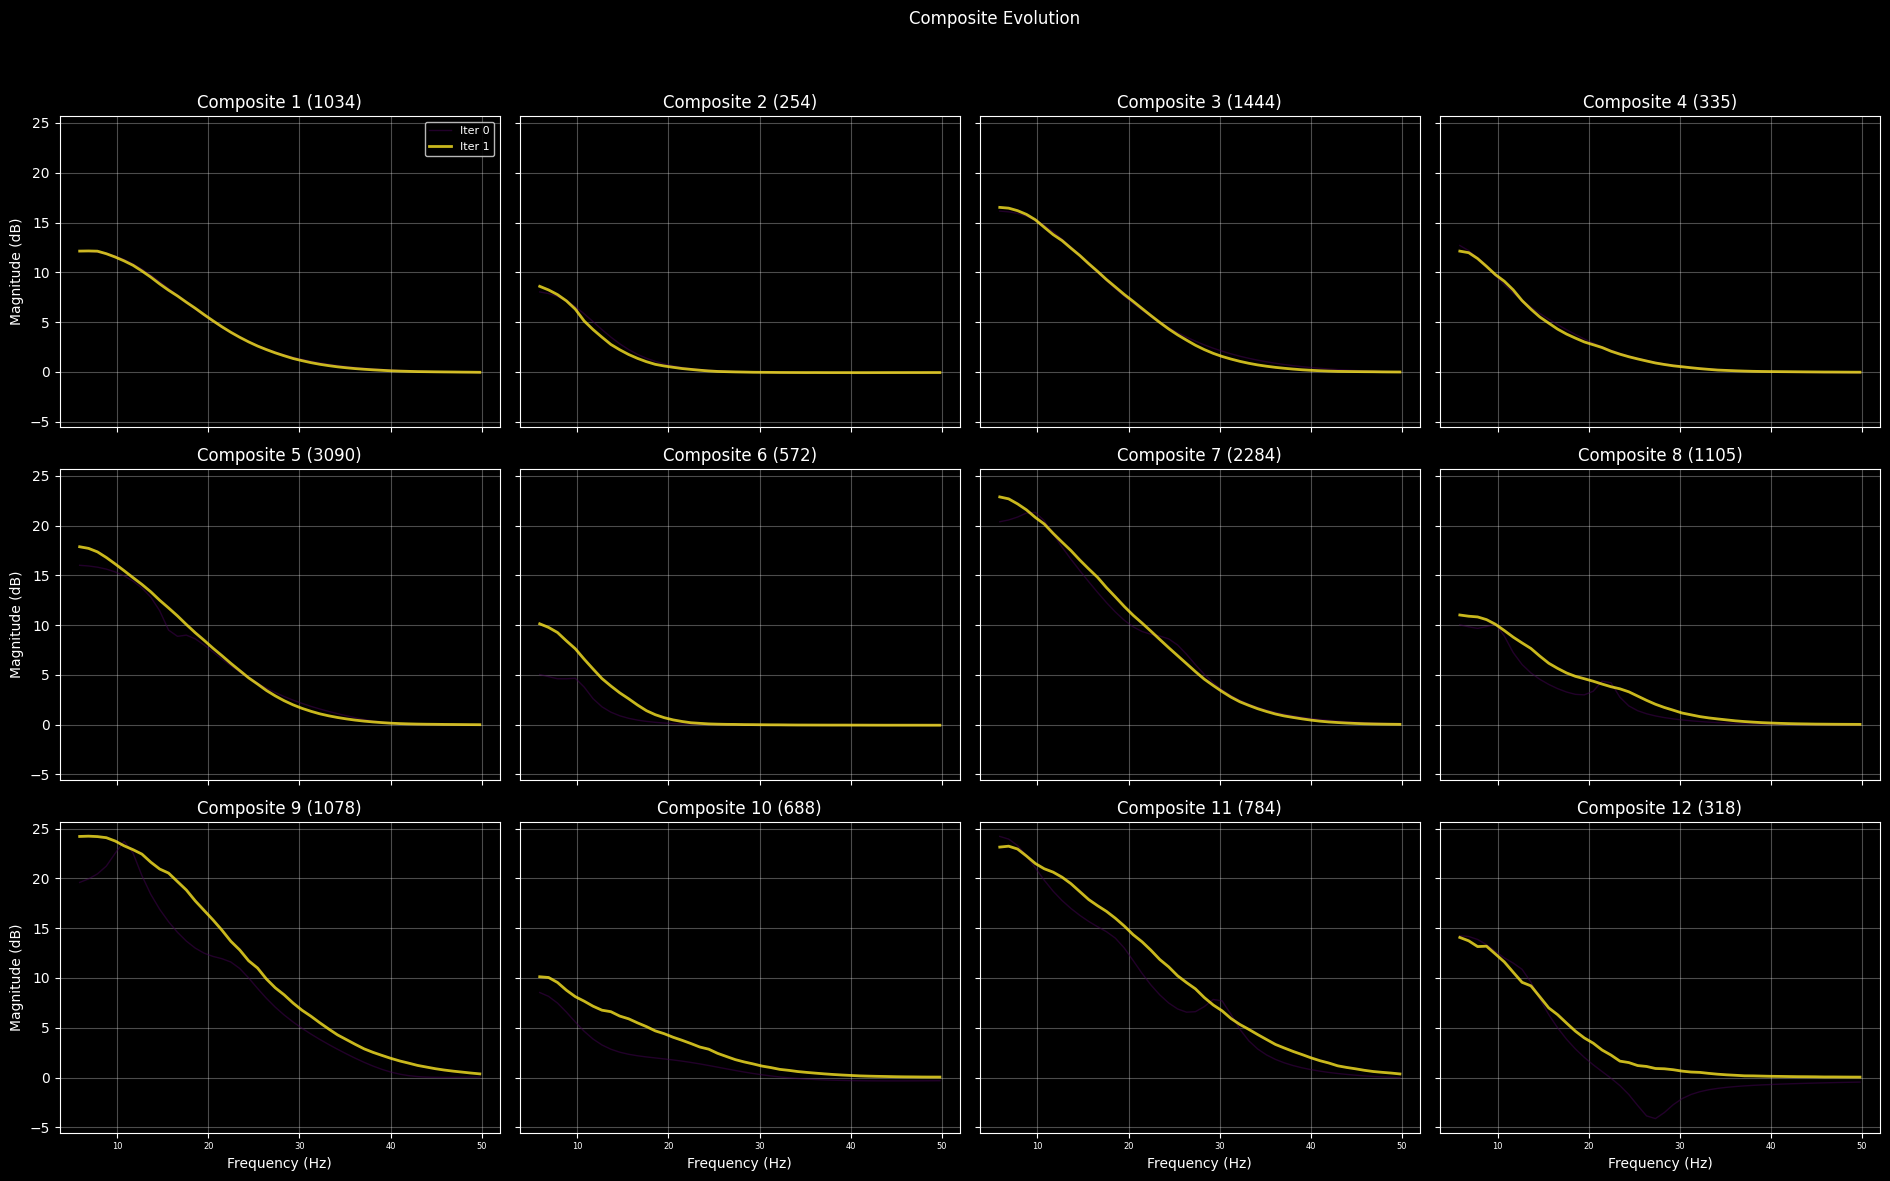

In [7]:
from beqanalyser.reporter import plot_composite_evolution

plot_composite_evolution(result, freqs, band=(min_freq, max_freq))

In [8]:
import logging
from beqanalyser.reporter import summarise_result, print_assignments, summarise_assignments

print_assignments(result.composites, catalogue)
summarise_result(result)
for i, c in enumerate(result.calculations, start=1):
    summarise_assignments(i, c, level=logging.INFO)

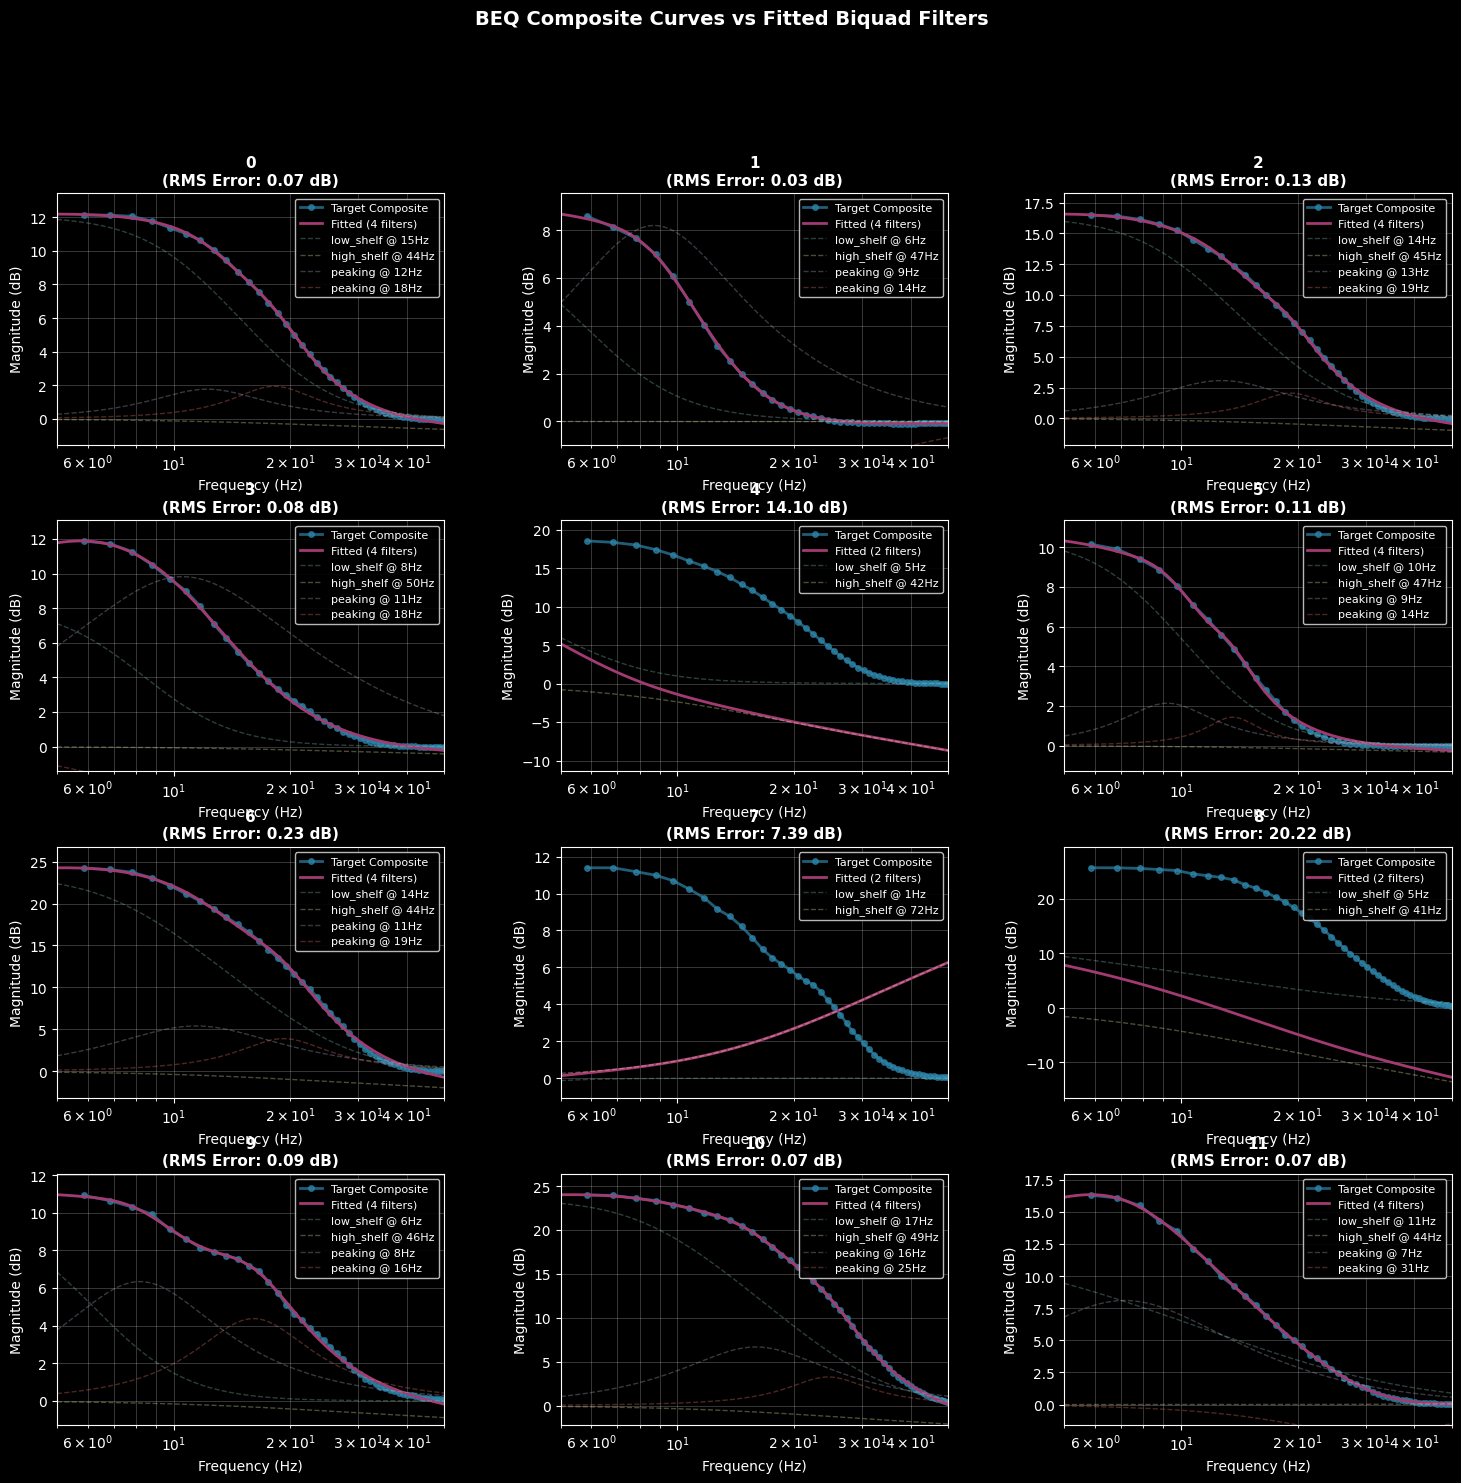

In [14]:
from beqanalyser.reporter import plot_filter_comparison
from beqanalyser.filter import CompositeCurveFitter, FilterLimits

fitter = CompositeCurveFitter(fs=48000, freq_range=(5, 50), filter_limits=FilterLimits(
    peaking_q=(0.5, 5.0),
    shelf_q=(0.3, 1.0),
    gain_range=(-40.0, 40.0),
    max_peaking_filters=2,
))
for composite in result.composites:
    biquads, metrics = fitter.fit_curve(in_band_freqs, composite.mag_response, max_filters=8)
    composite.biquads = biquads

curves = {f'{c.id}': (in_band_freqs, c.mag_response) for c in result.composites}
filts = {f'{c.id}': c.biquads for c in result.composites}
plot_filter_comparison(curves, filts)